# Imports

In [608]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [609]:
import re
import seaborn as sns
import tensorflow as tf

In [610]:
from wordcloud import WordCloud

In [611]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

# Loading the Data

In [612]:
target = ['sentiment', 'text']
df = pd.read_csv('../../data/raw/sentimentDataset/train.csv',
                encoding='ISO-8859-1',
                usecols=target)
df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [613]:
print(df.shape)
print(df.isnull().sum())
print(df.duplicated().sum())
print(df.info())

(27481, 2)
text         1
sentiment    0
dtype: int64
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB
None


In [614]:
print(df['sentiment'].isna().sum())
print(df['sentiment'].isnull().sum())

0
0


In [615]:
df['sentiment'] = df['sentiment'].fillna('neutral')

# Data Exploration, Tokenization, Padding, Labeling Target, Data Spliting and Model Training(without lemmatization and stopwords)

In [616]:
def clean(text):
    text = re.sub(r'[^\w\s]', '', text)
    # Conver to lower
    text = text.lower()
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [617]:
data1 = df

In [618]:
data1['text'] = data1['text'].fillna('')
data1['text'] = data1['text'].apply(clean)

In [619]:
for i in range(10):
    print(data1['text'][i+1])

sooo sad i will miss you here in san diego
my boss is bullying me
what interview leave me alone
sons of why couldnt they put them on the releases we already bought
httpwwwdothebouncycomsmf some shameless plugging for the best rangers forum on earth
2am feedings for the baby are fun when he is all smiles and coos
soooo high
both of you
journey wow u just became cooler hehe is that possible
as much as i love to be hopeful i reckon the chances are minimal p im never gonna get my cake and stuff


## Data Exploration 

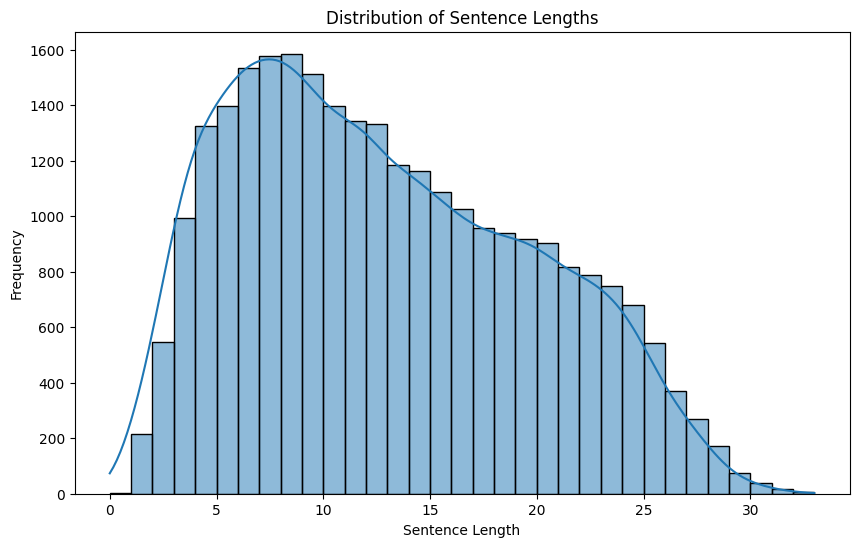

In [620]:
# sentence-length distribution
senLen = [len(text.split()) for text in data1['text']]
plt.figure(figsize=(10, 6))
sns.histplot(senLen, bins=range(min(senLen), max(senLen) + 1, 1), kde=True)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

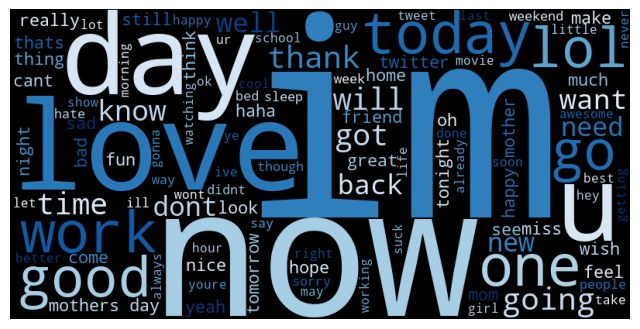

In [621]:
# worlCloud for all texts
allText = ' '.join(data1['text'])
cloud = WordCloud(width=800, height=400,
                  background_color='black',
                  min_font_size=12, max_words=350, colormap='Blues').generate(allText)
plt.figure(figsize = (8, 8))
plt.imshow(cloud)
plt.axis("off")
 
plt.show()

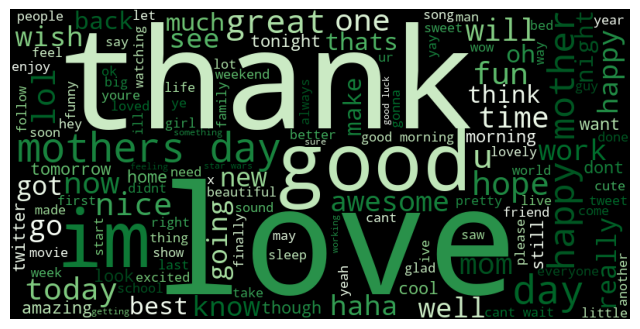

In [622]:
# worlCloud for positive texts
posText = ' '.join(data1[data1['sentiment'] == 'positive']['text'])
cloud = WordCloud(width=800, height=400,
                  background_color='black',
                  min_font_size=12, max_words=350, colormap='Greens').generate(posText)
plt.figure(figsize = (8, 8))
plt.imshow(cloud)
plt.axis("off")
 
plt.show()

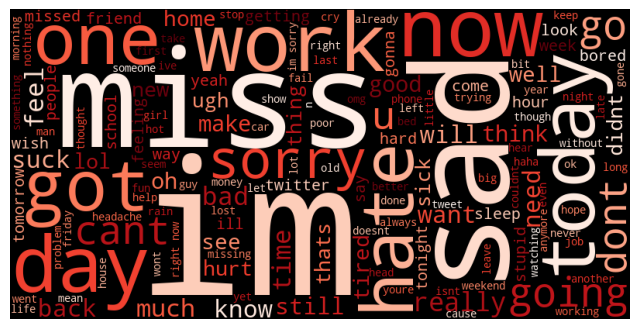

In [623]:
# worlCloud for negative texts
negText = ' '.join(data1[data1['sentiment'] == 'negative']['text'])
cloud = WordCloud(width=800, height=400,
                  background_color='black',
                  min_font_size=12, max_words=350, colormap='Reds').generate(negText)
plt.figure(figsize = (8, 8))
plt.imshow(cloud)
plt.axis("off")
 
plt.show()

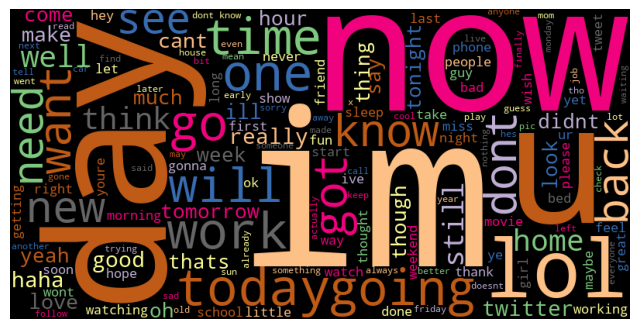

In [624]:
# worlCloud for neutral texts
neuText = ' '.join(data1[data1['sentiment'] == 'neutral']['text'])
cloud = WordCloud(width=800, height=400,
                  background_color='black',
                  min_font_size=12, max_words=350, colormap='Accent').generate(neuText)
plt.figure(figsize = (8, 8))
plt.imshow(cloud)
plt.axis("off")
 
plt.show()

### Tokenization, Padding and Labeling

In [625]:
#Tokenizing Text
tokenizer = Tokenizer(num_words=7552)
tokenizer.fit_on_texts(data1['text'])
sequence = tokenizer.texts_to_sequences(data1['text'])
vocabSize = 7552 + 1

In [626]:
#Padding the Sequences
maxLength = int(np.percentile(([len(text.split()) for text in data1['text']]), 95))
paddedSeq = pad_sequences(sequence, maxLength, padding='post')

In [627]:
#Data Labeling
lables = pd.get_dummies(data1['sentiment']).values

XTrain, XTest, yTrain, yTest = train_test_split(paddedSeq, lables, test_size=0.4)
print(XTrain)
print(yTrain)

[[ 414    1   27 ...    0    0    0]
 [  30   95  190 ...    0    0    0]
 [  13  146    3 ...    0    0    0]
 ...
 [6580  834   14 ...    0    0    0]
 [  13   20  285 ...    0    0    0]
 [6589    2  293 ...    0    0    0]]
[[False False  True]
 [False False  True]
 [False  True False]
 ...
 [False  True False]
 [False  True False]
 [ True False False]]


### RNN Model

In [628]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM

In [629]:
#Params
embeddingDim = 100

In [630]:
#Model
model = Sequential([
    Embedding(vocabSize, embeddingDim, input_length=maxLength),
    SimpleRNN(128),
    Dense(3, activation='softmax')
])

model.build(input_shape=(None, maxLength))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/Users/chaitanyasingh/Documents/Project/10/venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_24 (Embedding)        │ (None, 25, 100)        │       755,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_16 (SimpleRNN)       │ (None, 128)            │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 784,999 (2.99 MB)

 Trainable params: 784,999 (2.99 MB)

 Non-trainable params: 0 (0.00 B)

In [631]:
#Training Model
history = model.fit(
    XTrain, yTrain,
    validation_data=(XTest, yTest),
    epochs=30,
    batch_size=2,
    verbose=1
)

Epoch 1/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - accuracy: 0.3641 - loss: 1.1318 - val_accuracy: 0.3490 - val_loss: 1.1243
Epoch 2/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.3643 - loss: 1.1184 - val_accuracy: 0.3631 - val_loss: 1.1392
Epoch 3/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.3677 - loss: 1.1165 - val_accuracy: 0.4052 - val_loss: 1.0955
Epoch 4/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.3648 - loss: 1.1155 - val_accuracy: 0.3328 - val_loss: 1.1036
Epoch 5/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.3641 - loss: 1.1144 - val_accuracy: 0.4023 - val_loss: 1.0932
Epoch 6/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.3755 - loss: 1.1140 - val_accuracy: 0.3658 - val_loss: 1.1207
Epoch 7/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.3638 - loss: 1.1140 - val_accuracy: 0.4058 - val_loss: 1.1174
Epoch 8/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.3782 - loss: 1

In [632]:
#Evaluate Model
loss, acc = model.evaluate(XTest, yTest, verbose=1)
print(f'Test Accuracy: {acc:.4f}')
print(f'Test Loss: {loss:.4f}')

344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3315 - loss: 1.1466
Test Accuracy: 0.3271
Test Loss: 1.1509


In [633]:
text = [
    "The seemingly insurmountable challenges faced by the team were addressed with such extraordinary creativity and unwavering determination that the initially skeptical stakeholders were ultimately left in awe.",
    "Despite the chef's commendable attempt at a fusion dish, the overwhelming mix of flavors led to a confusing palate experience that was more displeasing than delightful."
]
testSeq = tokenizer.texts_to_sequences(text)
testLine = pad_sequences(testSeq, maxLength)
pred = model.predict(testLine)

predClassIndex = np.argmax(pred, axis=1)
classNames = ['negative', 'neutral', 'positive']
predClass = [classNames[index] for index in predClassIndex]

print(f"Predicted class: {predClass}")
print(f"Prediction probabilities: {pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Predicted class: ['neutral', 'neutral']
Prediction probabilities: [[0.00921033 0.9614653  0.02932442]
 [0.01469199 0.93204755 0.05326036]]


### LSTM Model

In [634]:
#Model
model = Sequential([
    Embedding(vocabSize, embeddingDim, input_length=maxLength),
    LSTM(64),
    Dense(3, activation='softmax')
])

model.build(input_shape=(None, maxLength))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_25 (Embedding)        │ (None, 25, 100)        │       755,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 797,735 (3.04 MB)

 Trainable params: 797,735 (3.04 MB)

 Non-trainable params: 0 (0.00 B)

In [635]:
#Training Model
history = model.fit(
    XTrain, yTrain,
    validation_data=(XTest, yTest),
    epochs=30,
    batch_size=2,
    verbose=1
)

#Evaluate Model
loss, acc = model.evaluate(XTest, yTest, verbose=1)
print(f'Test Accuracy: {acc:.4f}')
print(f'Test Loss: {loss:.4f}')

Epoch 1/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - accuracy: 0.5099 - loss: 0.9717 - val_accuracy: 0.6942 - val_loss: 0.7283
Epoch 2/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.7460 - loss: 0.6381 - val_accuracy: 0.7125 - val_loss: 0.7053
Epoch 3/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.8100 - loss: 0.4936 - val_accuracy: 0.6995 - val_loss: 0.7368
Epoch 4/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.8600 - loss: 0.3793 - val_accuracy: 0.6791 - val_loss: 0.8754
Epoch 5/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.9006 - loss: 0.2723 - val_accuracy: 0.6799 - val_loss: 0.9167
Epoch 6/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.9256 - loss: 0.2085 - val_accuracy: 0.6672 - val_loss: 1.0653
Epoch 7/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.9466 - loss: 0.1536 - val_accuracy: 0.6625 - val_loss: 1.2465
Epoch 8/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.9638 - loss: 0

In [636]:
text = [
    "The seemingly insurmountable challenges faced by the team were addressed with such extraordinary creativity and unwavering determination that the initially skeptical stakeholders were ultimately left in awe.",
    "Despite the chef's commendable attempt at a fusion dish, the overwhelming mix of flavors led to a confusing palate experience that was more displeasing than delightful."
]
testSeq = tokenizer.texts_to_sequences(text)
testLine = pad_sequences(testSeq, maxLength)
pred = model.predict(testLine)

predClassIndex = np.argmax(pred, axis=1)
classNames = ['negative', 'neutral', 'positive']
predClass = [classNames[index] for index in predClassIndex]

print(f"Predicted class: {predClass}")
print(f"Prediction probabilities: {pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Predicted class: ['negative', 'neutral']
Prediction probabilities: [[4.5576161e-01 2.7255204e-01 2.7168632e-01]
 [7.1427305e-05 9.9991584e-01 1.2769391e-05]]


# Data Exploration, Tokenization, Padding, Labeling Target, Data Spliting and Model Training(with lemmatization and stopwords)

In [670]:
from nltk.stem import WordNetLemmatizer
import nltk

In [671]:
import lime
import lime.lime_text
from sklearn.pipeline import make_pipeline
import ssl

In [672]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

In [673]:
from nltk.corpus import stopwords

In [674]:
#pre-processing texts
def preprocessText(text):
    if not isinstance(text, str):
        return text
    
    #lowercasing
    text = text.lower()
    
    #removing special characters and punctuations
    text = re.sub(r'[^\w\s]', '', text)
    
    #removing URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Removing stop-words
    stop_words = set(stopwords.words("english"))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    #lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

In [675]:
data2 = df

In [676]:
data2['text'] = data2['text'].apply(clean)

### Data Exploration

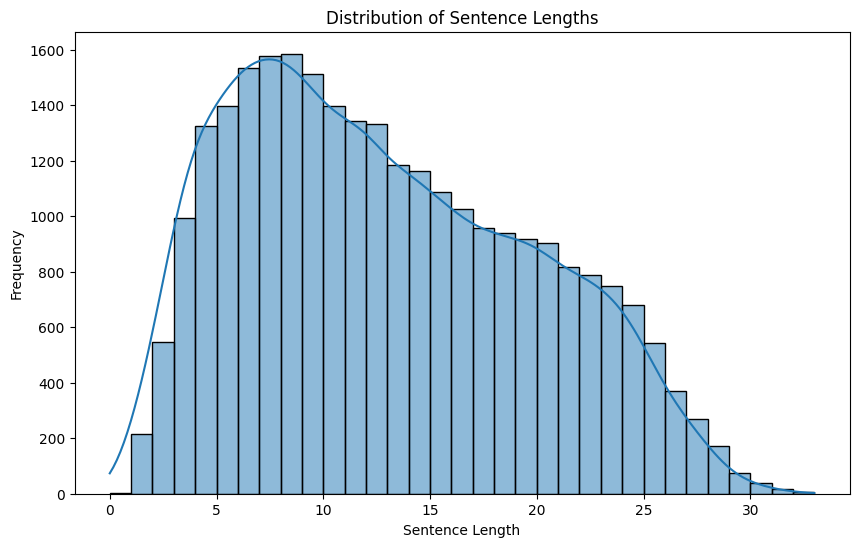

In [677]:
# sentence-length distribution
senLen = [len(text.split()) for text in data1['text']]
plt.figure(figsize=(10, 6))
sns.histplot(senLen, bins=range(min(senLen), max(senLen) + 1, 1), kde=True)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

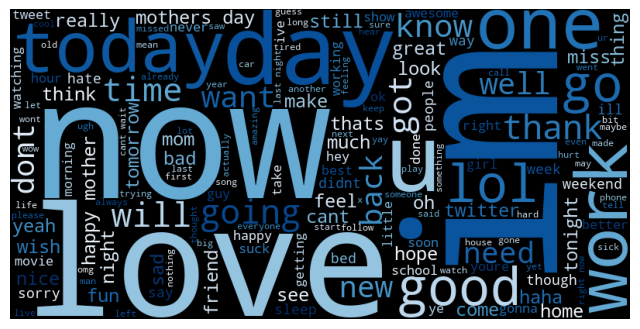

In [678]:
# worlCloud for all texts
allText = ' '.join(data1['text'])
cloud = WordCloud(width=800, height=400,
                  background_color='black',
                  min_font_size=12, max_words=350, colormap='Blues').generate(allText)
plt.figure(figsize = (8, 8))
plt.imshow(cloud)
plt.axis("off")
 
plt.show()

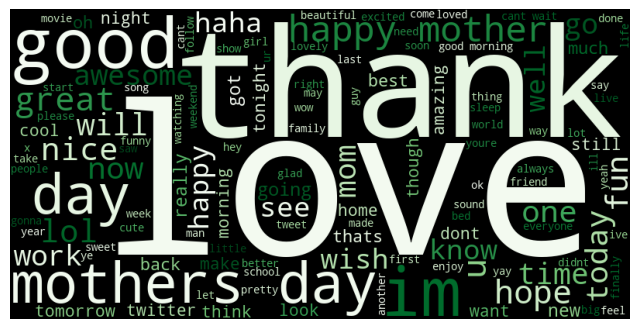

In [679]:
# worlCloud for positive texts
posText = ' '.join(data1[data1['sentiment'] == 'positive']['text'])
cloud = WordCloud(width=800, height=400,
                  background_color='black',
                  min_font_size=12, max_words=350, colormap='Greens').generate(posText)
plt.figure(figsize = (8, 8))
plt.imshow(cloud)
plt.axis("off")
 
plt.show()

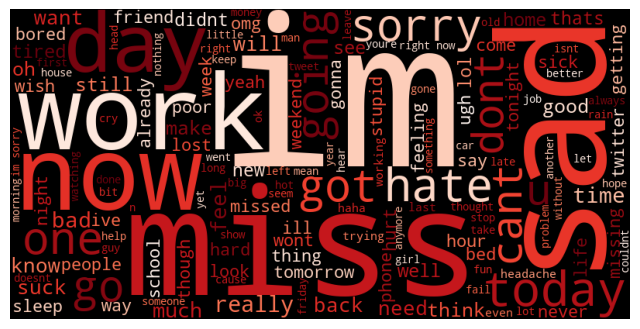

In [680]:
# worlCloud for negative texts
negText = ' '.join(data1[data1['sentiment'] == 'negative']['text'])
cloud = WordCloud(width=800, height=400,
                  background_color='black',
                  min_font_size=12, max_words=350, colormap='Reds').generate(negText)
plt.figure(figsize = (8, 8))
plt.imshow(cloud)
plt.axis("off")
 
plt.show()

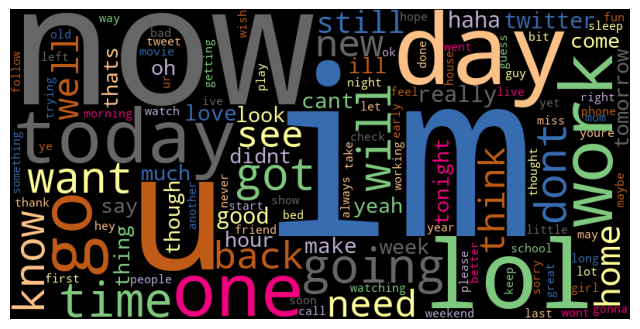

In [681]:
# worlCloud for neutral texts
neuText = ' '.join(data1[data1['sentiment'] == 'neutral']['text'])
cloud = WordCloud(width=800, height=400,
                  background_color='black',
                  min_font_size=12, max_words=350, colormap='Accent').generate(neuText)
plt.figure(figsize = (8, 8))
plt.imshow(cloud)
plt.axis("off")
 
plt.show()

### Tokenization, Padding and Data Labeling

In [682]:
#Tokenizing Text
tokenizer = Tokenizer(num_words=7552)
tokenizer.fit_on_texts(data2['text'])
sequence = tokenizer.texts_to_sequences(data2['text'])

vocabSize = 7552 + 1

In [683]:
#Padding the Sequences
maxLength = int(np.percentile(([len(text.split()) for text in data2['text']]), 95))
paddedSeq = pad_sequences(sequence, maxLength, padding='post')

In [684]:
#Data Labeling
lables = pd.get_dummies(data2['sentiment']).values

XTrain, XTest, yTrain, yTest = train_test_split(paddedSeq, lables, test_size=0.4)
print(XTrain)
print(yTrain)

[[   9 1120   11 ...    0    0    0]
 [  71  240    0 ...    0    0    0]
 [ 133  367   30 ...    0    0    0]
 ...
 [ 300    2    3 ...    0    0    0]
 [  13  123  542 ...    0    0    0]
 [  37 1092   62 ...    0    0    0]]
[[False  True False]
 [False  True False]
 [False False  True]
 ...
 [False  True False]
 [ True False False]
 [ True False False]]


### RNN Model

In [685]:
#Params
embeddingDim = 100

In [653]:
#Model
model = Sequential([
    Embedding(vocabSize, embeddingDim, input_length=maxLength),
    SimpleRNN(128),
    Dense(3, activation='softmax')
])

model.build(input_shape=(None, maxLength))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/Users/chaitanyasingh/Documents/Project/10/venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_26 (Embedding)        │ (None, 25, 100)        │       755,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_17 (SimpleRNN)       │ (None, 128)            │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 784,999 (2.99 MB)

 Trainable params: 784,999 (2.99 MB)

 Non-trainable params: 0 (0.00 B)

In [654]:
#Training Model
history = model.fit(
    XTrain, yTrain,
    validation_data=(XTest, yTest),
    epochs=30,
    batch_size=2,
    verbose=1
)

Epoch 1/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.3713 - loss: 1.1268 - val_accuracy: 0.4038 - val_loss: 1.0902
Epoch 2/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.3712 - loss: 1.1143 - val_accuracy: 0.3576 - val_loss: 1.1046
Epoch 3/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.3658 - loss: 1.1175 - val_accuracy: 0.3220 - val_loss: 1.1180
Epoch 4/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.3698 - loss: 1.1151 - val_accuracy: 0.4037 - val_loss: 1.0900
Epoch 5/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.3655 - loss: 1.1184 - val_accuracy: 0.3741 - val_loss: 1.1073
Epoch 6/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.3744 - loss: 1.1136 - val_accuracy: 0.4034 - val_loss: 1.0910
Epoch 7/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.3744 - loss: 1.1159 - val_accuracy: 0.3513 - val_loss: 1.0956
Epoch 8/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - accuracy: 0.3658 - loss: 1

In [655]:
#Evaluate Model
loss, acc = model.evaluate(XTest, yTest, verbose=1)
print(f'Test Accuracy: {acc:.4f}')
print(f'Test Loss: {loss:.4f}')

344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3984 - loss: 1.1417
Test Accuracy: 0.4007
Test Loss: 1.1395


In [656]:
#Model-Prediction
text = [
    "The seemingly insurmountable challenges faced by the team were addressed with such extraordinary creativity and unwavering determination that the initially skeptical stakeholders were ultimately left in awe.",
    "Despite the chef's commendable attempt at a fusion dish, the overwhelming mix of flavors led to a confusing palate experience that was more displeasing than delightful."
]
testSeq = tokenizer.texts_to_sequences(text)
testLine = pad_sequences(testSeq, maxLength)
pred = model.predict(testLine)

predClassIndex = np.argmax(pred, axis=1)
classNames = ['negative', 'neutral', 'positive']
predClass = [classNames[index] for index in predClassIndex]

print(f"Predicted class: {predClass}")
print(f"Prediction probabilities: {pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Predicted class: ['neutral', 'negative']
Prediction probabilities: [[0.33982033 0.56851995 0.09165973]
 [0.85418886 0.10941602 0.03639506]]


#### ROC-ACU Score

In [657]:
from sklearn.metrics import roc_auc_score
pred = model.predict(XTest)
rocAuc = roc_auc_score(yTest, pred)
print('ROC-ACU Score: ', rocAuc)

344/344 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
ROC-ACU Score:  0.5077184335813394


### Model F1-Score

In [658]:
from sklearn.metrics import classification_report

In [659]:
predClasses = np.argmax(pred, axis=1)
yTrue = np.argmax(yTest, axis=1)

print(classification_report(yTrue, predClasses, target_names=['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.32      0.03      0.06      3097
     neutral       0.41      0.94      0.57      4441
    positive       0.33      0.04      0.07      3455

    accuracy                           0.40     10993
   macro avg       0.35      0.34      0.23     10993
weighted avg       0.36      0.40      0.27     10993



### LSTM Model

In [660]:
#Model
model = Sequential([
    Embedding(vocabSize, embeddingDim, input_length=maxLength),
    LSTM(64),
    Dense(3, activation='softmax')
])

model.build(input_shape=(None, maxLength))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/Users/chaitanyasingh/Documents/Project/10/venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_27 (Embedding)        │ (None, 25, 100)        │       755,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 797,735 (3.04 MB)

 Trainable params: 797,735 (3.04 MB)

 Non-trainable params: 0 (0.00 B)

In [661]:
#Training Model
history = model.fit(
    XTrain, yTrain,
    validation_data=(XTest, yTest),
    epochs=12,
    batch_size=2,
    verbose=1
)

#Evaluate Model
loss, acc = model.evaluate(XTest, yTest, verbose=1)
print(f'Test Accuracy: {acc:.4f}')
print(f'Test Loss: {loss:.4f}')

Epoch 1/12
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.5029 - loss: 0.9788 - val_accuracy: 0.7028 - val_loss: 0.7155
Epoch 2/12
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.7445 - loss: 0.6258 - val_accuracy: 0.7229 - val_loss: 0.6767
Epoch 3/12
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.8217 - loss: 0.4650 - val_accuracy: 0.7104 - val_loss: 0.7091
Epoch 4/12
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.8619 - loss: 0.3614 - val_accuracy: 0.7014 - val_loss: 0.8232
Epoch 5/12
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - accuracy: 0.9050 - loss: 0.2673 - val_accuracy: 0.6779 - val_loss: 0.9149
Epoch 6/12
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 2113s 256ms/step - accuracy: 0.9312 - loss: 0.1908 - val_accuracy: 0.6819 - val_loss: 1.0776
Epoch 7/12
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 250s 30ms/step - accuracy: 0.9491 - loss: 0.1411 - val_accuracy: 0.6730 - val_loss: 1.2680
Epoch 8/12
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.9626 - l

In [662]:
#Model-Prediction
text = [
    "The seemingly insurmountable challenges faced by the team were addressed with such extraordinary creativity and unwavering determination that the initially skeptical stakeholders were ultimately left in awe.",
    "Despite the chef's commendable attempt at a fusion dish, the overwhelming mix of flavors led to a confusing palate experience that was more displeasing than delightful."
]
testSeq = tokenizer.texts_to_sequences(text)
testLine = pad_sequences(testSeq, maxLength)
pred = model.predict(testLine)

predClassIndex = np.argmax(pred, axis=1)
classNames = ['negative', 'neutral', 'positive']
predClass = [classNames[index] for index in predClassIndex]

print(f"Predicted class: {predClass}")
print(f"Prediction probabilities: {pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Predicted class: ['positive', 'negative']
Prediction probabilities: [[0.00322137 0.02093627 0.9758423 ]
 [0.7048652  0.03573228 0.25940257]]


### ROC-ACU Score

In [663]:
pred = model.predict(XTest)
rocAuc = roc_auc_score(yTest, pred)
print('ROC-ACU Score: ', rocAuc)

344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
ROC-ACU Score:  0.7962423514727527


### Model F1-Score

In [664]:
from sklearn.metrics import classification_report

In [665]:
predClasses = np.argmax(pred, axis=1)
yTrue = np.argmax(yTest, axis=1)

print(classification_report(yTrue, predClasses, target_names=['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.65      0.62      0.63      3097
     neutral       0.61      0.63      0.62      4441
    positive       0.70      0.70      0.70      3455

    accuracy                           0.65     10993
   macro avg       0.65      0.65      0.65     10993
weighted avg       0.65      0.65      0.65     10993



## Optimizing LSTM Model

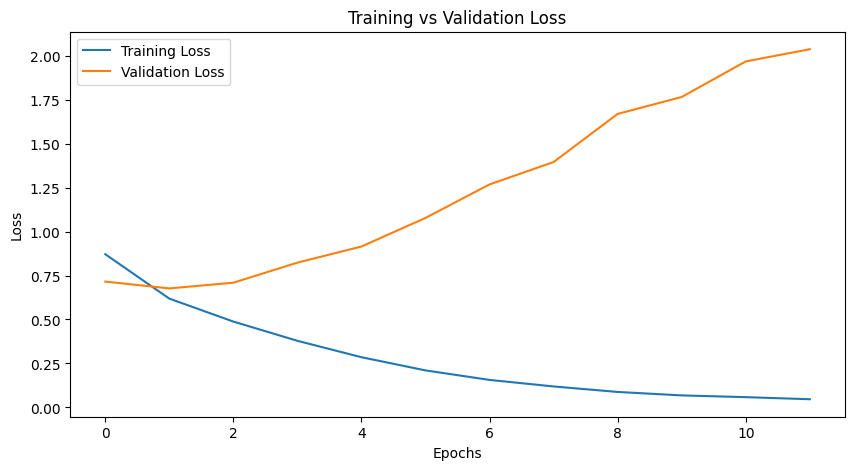

In [666]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

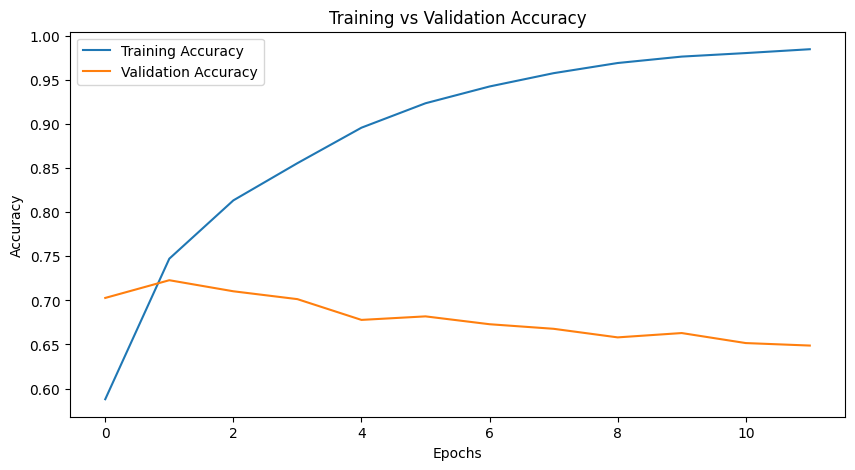

In [667]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [686]:
### Dropout Layer
from tensorflow.keras.layers import Dropout

In [689]:
model = Sequential([
    Embedding(input_dim=vocabSize, output_dim=embeddingDim, input_length=maxLength),
    Dropout(0.5),
    LSTM(64),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

In [690]:
model.build(input_shape=(None, maxLength))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_31 (Embedding)        │ (None, 25, 100)        │       755,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 797,735 (3.04 MB)

 Trainable params: 797,735 (3.04 MB)

 Non-trainable params: 0 (0.00 B)

In [691]:
history = model.fit(
    XTrain, yTrain,
    validation_data=(XTest, yTest),
    epochs=30,
    batch_size=2,
    verbose=1,
)

Epoch 1/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 47s 6ms/step - accuracy: 0.4457 - loss: 1.0467 - val_accuracy: 0.6719 - val_loss: 0.7694
Epoch 2/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.7058 - loss: 0.7180 - val_accuracy: 0.7055 - val_loss: 0.6969
Epoch 3/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.7724 - loss: 0.5844 - val_accuracy: 0.7067 - val_loss: 0.6933
Epoch 4/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.8115 - loss: 0.5010 - val_accuracy: 0.7108 - val_loss: 0.7113
Epoch 5/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.8358 - loss: 0.4506 - val_accuracy: 0.7062 - val_loss: 0.7337
Epoch 6/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 48s 6ms/step - accuracy: 0.8522 - loss: 0.4054 - val_accuracy: 0.6956 - val_loss: 0.7829
Epoch 7/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.8708 - loss: 0.3589 - val_accuracy: 0.6905 - val_loss: 0.8841
Epoch 8/30
8244/8244 ━━━━━━━━━━━━━━━━━━━━ 49s 6ms/step - accuracy: 0.8818 - loss: 0

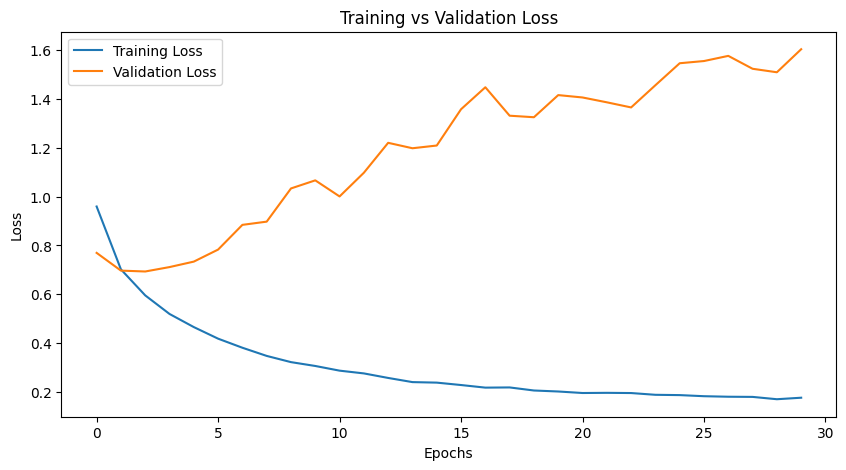

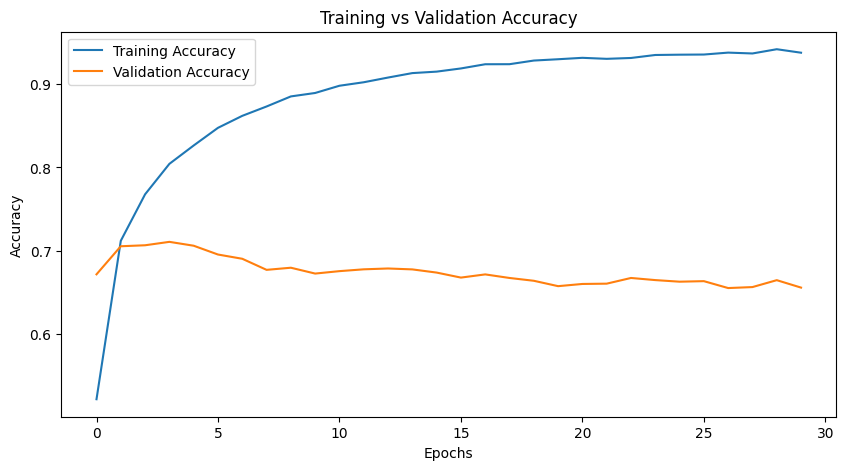

In [693]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [694]:
### Regularization
from tensorflow.keras.regularizers import l2

In [701]:
model = Sequential([
    Embedding(input_dim=vocabSize, output_dim=embeddingDim, input_length=maxLength),
    Dropout(0.5),
    LSTM(64, kernel_regularizer=l2(0.001)),
    Dropout(0.9),
    Dense(3, activation='softmax')
])

In [702]:
model.build(input_shape=(None, maxLength))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_33 (Embedding)        │ (None, 25, 100)        │       755,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 25, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 797,735 (3.04 MB)

 Trainable params: 797,735 (3.04 MB)

 Non-trainable params: 0 (0.00 B)

In [706]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    XTrain, yTrain,
    validation_data=(XTest, yTest),
    epochs=15,
    batch_size=10,
    verbose=1
)

Epoch 1/15
1649/1649 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7509 - loss: 0.6668 - val_accuracy: 0.6936 - val_loss: 0.7618
Epoch 2/15
1649/1649 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7723 - loss: 0.6277 - val_accuracy: 0.6876 - val_loss: 0.7561
Epoch 3/15
1649/1649 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7889 - loss: 0.5882 - val_accuracy: 0.6967 - val_loss: 0.7997
Epoch 4/15
1649/1649 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7984 - loss: 0.5836 - val_accuracy: 0.6860 - val_loss: 0.7914
Epoch 5/15
1649/1649 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8098 - loss: 0.5412 - val_accuracy: 0.6786 - val_loss: 0.9455
Epoch 6/15
1649/1649 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8192 - loss: 0.5274 - val_accuracy: 0.6835 - val_loss: 0.8227
Epoch 7/15
1649/1649 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8354 - loss: 0.4883 - val_accuracy: 0.6836 - val_loss: 0.8734
Epoch 8/15
1649/1649 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8416 - loss: 0

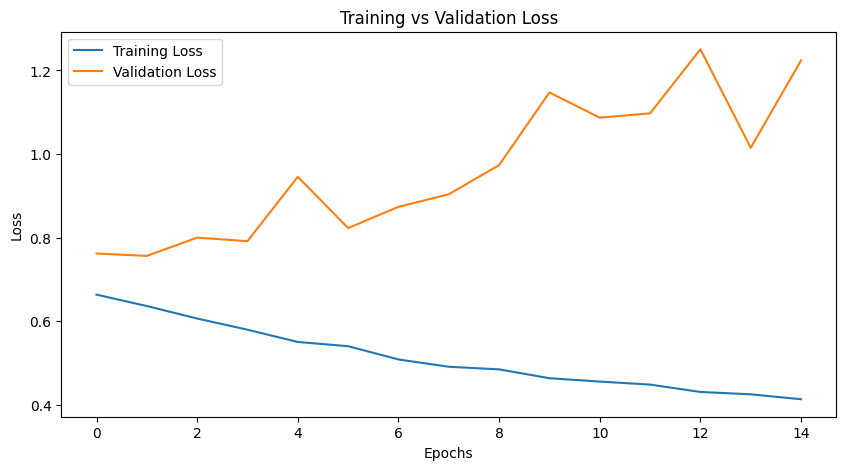

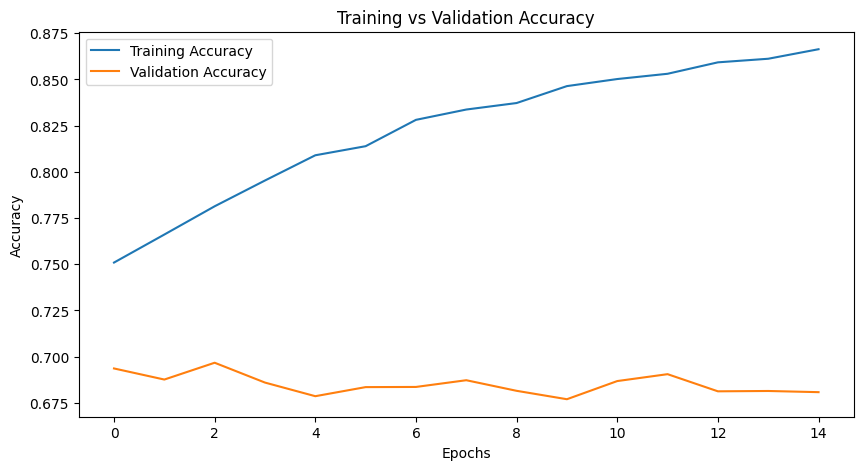

In [707]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [708]:
#Model-Prediction
text = [
    "The seemingly insurmountable challenges faced by the team were addressed with such extraordinary creativity and unwavering determination that the initially skeptical stakeholders were ultimately left in awe.",
    "Despite the chef's commendable attempt at a fusion dish, the overwhelming mix of flavors led to a confusing palate experience that was more displeasing than delightful."
]
testSeq = tokenizer.texts_to_sequences(text)
testLine = pad_sequences(testSeq, maxLength)
pred = model.predict(testLine)

predClassIndex = np.argmax(pred, axis=1)
classNames = ['negative', 'neutral', 'positive']
predClass = [classNames[index] for index in predClassIndex]

print(f"Predicted class: {predClass}")
print(f"Prediction probabilities: {pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Predicted class: ['neutral', 'negative']
Prediction probabilities: [[0.05178535 0.9084024  0.03981229]
 [0.5539652  0.422567   0.02346769]]


In [712]:
pred = model.predict(XTest)
rocAuc = roc_auc_score(yTest, pred)
print('ROC-ACU Score: ', rocAuc)

344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
ROC-ACU Score:  0.8282250645061676


In [713]:
predClasses = np.argmax(pred, axis=1)
yTrue = np.argmax(yTest, axis=1)

print(classification_report(yTrue, predClasses, target_names=['negative', 'neutral', 'positive']))

              precision    recall  f1-score   support

    negative       0.71      0.61      0.66      3125
     neutral       0.62      0.70      0.66      4437
    positive       0.74      0.72      0.73      3431

    accuracy                           0.68     10993
   macro avg       0.69      0.68      0.68     10993
weighted avg       0.69      0.68      0.68     10993

